In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 586, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 586 (delta 207), reused 203 (delta 104), pack-reused 267 (from 1)
Receiving objects: 100% (586/586), 463.53 KiB | 1.82 MiB/s, done.
Resolving deltas: 100% (366/366), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.read_datasets import read_sipgate_dataset
from bin.utils.clean_sipgate_dataset import clean_sipgate_dataset
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [15]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [5]:
def results_to_dataframe(results: list[dict]):
    # Initialize an empty DataFrame
    columns = ["intent"] + list(list(results[0].values())[0]["results"].keys())
    df = pd.DataFrame(columns=columns)
    df.set_index("intent", inplace=True)

    # Process each intent dictionary
    for intent_dict in results:
        for intent_name, data in intent_dict.items():
            results = data["results"]
            df.loc[intent_name] = results

    df["intent"] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [6]:
def plot_results_df(df: pd.DataFrame, plot_func=plt.hist):
    # make a dashboard of plots
    # where each plot is the distribution of a metric
    # across all intents
    n_metrics = len([col for col in df.columns if not df[col].isnull().all()]) - 1
    n_cols = 2
    n_rows = n_metrics // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axs = axs.flatten()

    for i, metric in enumerate(df.columns[1:]):
        if metric == "intent" or df[metric].isnull().all():
            continue

        x, y = df[metric].index, df[metric].values

        ax = axs[i]
        sns.swarmplot(
            data=y,
            ax=ax,
            color="blue",
            alpha=0.5,
            linewidth=0,
        )
        ax.set_title(metric)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

In [22]:
dataset_name = "zero_shot_simple_data"
gen_df = pd.read_csv(f"data/{dataset_name}.csv", encoding="utf-8")
gen_df.rename(columns={"query": "text"}, inplace=True)
# remove rows with invalid values in text column
gen_df = gen_df[gen_df["text"].apply(lambda x: isinstance(x, str))]
ref_df = clean_sipgate_dataset(read_sipgate_dataset())

100%|██████████| 92/92 [05:21<00:00,  3.50s/it]
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 38.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399:

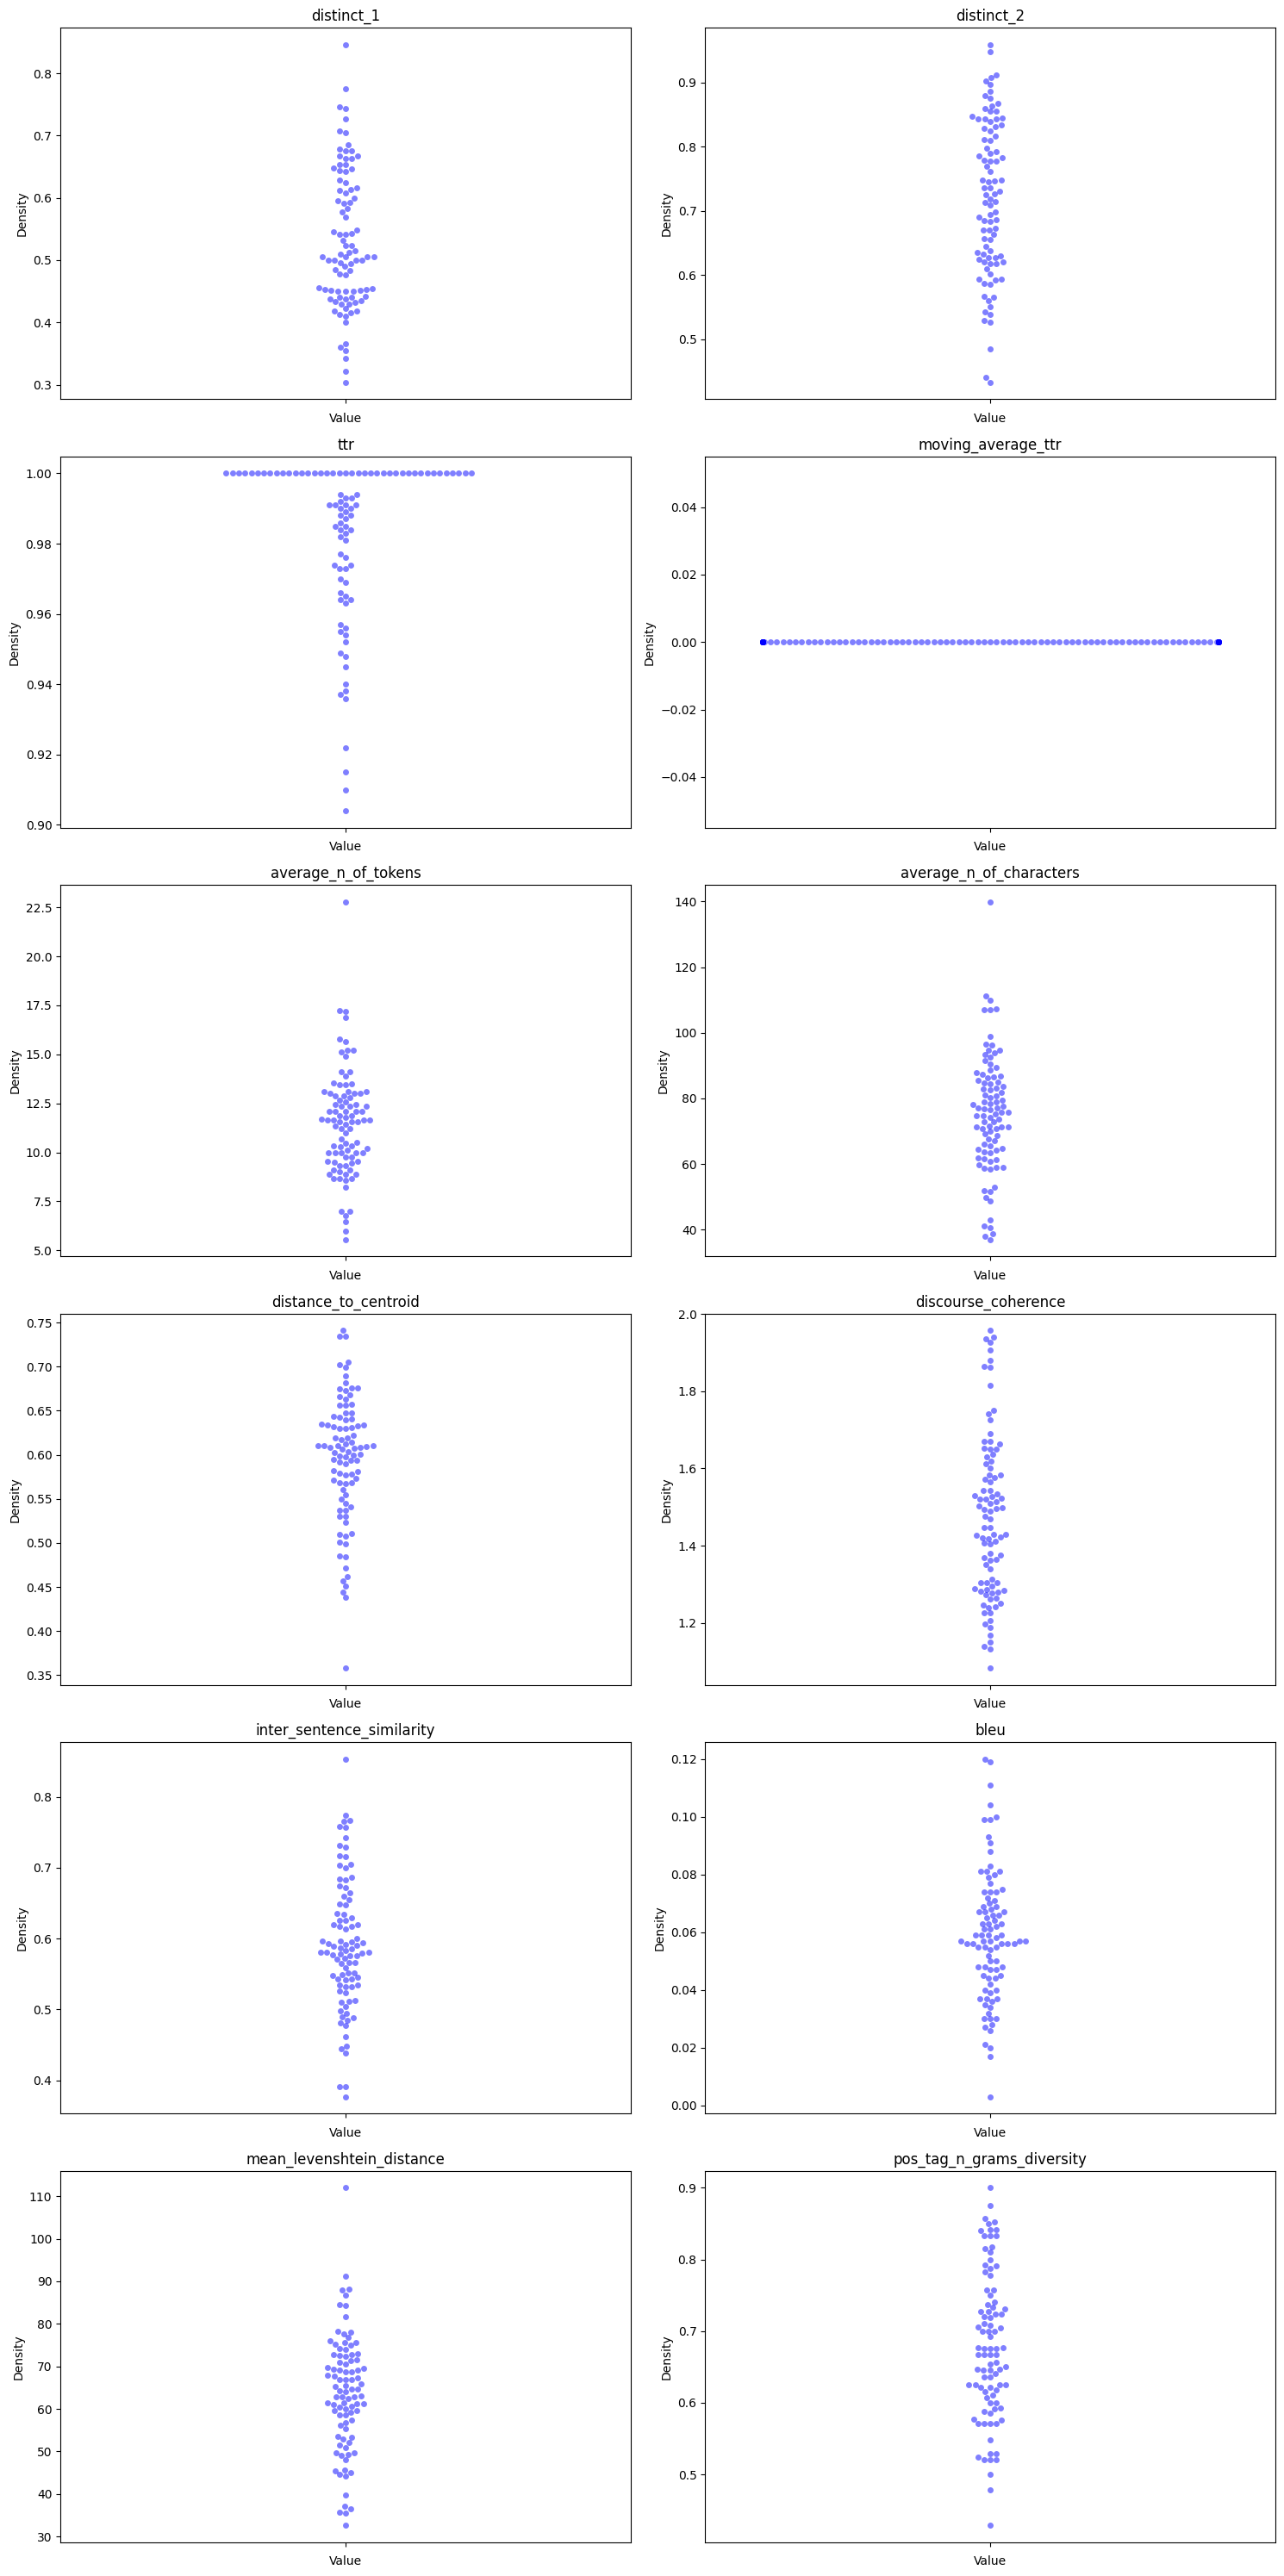

In [23]:
framework = Framework()
results = framework.apply_framework_to_datasets(gen_df, ref_df)
df = results_to_dataframe(results)
plot_results_df(df)